In [1]:
# Importing Necessory packages:
import numpy as np
import os
import sys
import datetime
import matplotlib.pyplot as plt
import cv2
import datetime
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Utils
import h5py

c:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
os.getcwd()

'/content/drive/MyDrive/170450 Segmentation Heart disease image'

In [7]:
cd '/content/drive/MyDrive/170450 Segmentation Heart disease image'

/content/drive/MyDrive/170450 Segmentation Heart disease image


## Loading the Images and Masks:

In [2]:
data = h5py.File("Dataset_2/image_dataset.hdf5", "r")

In [3]:
Images = data["train 2ch frames"][:,:,:,:]
Masks = data["train 2ch masks"][:,:,:,:]

In [4]:
print(Images.shape, Masks.shape)

(900, 384, 384, 1) (900, 384, 384, 1)


In [5]:
Images[0].shape

(384, 384, 1)

## Visualization of Images:

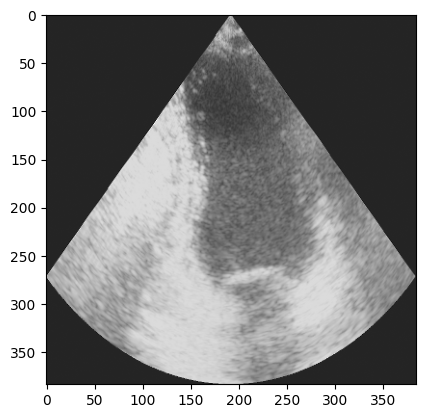

In [13]:
plt.imshow(Images[0],cmap ='gray')

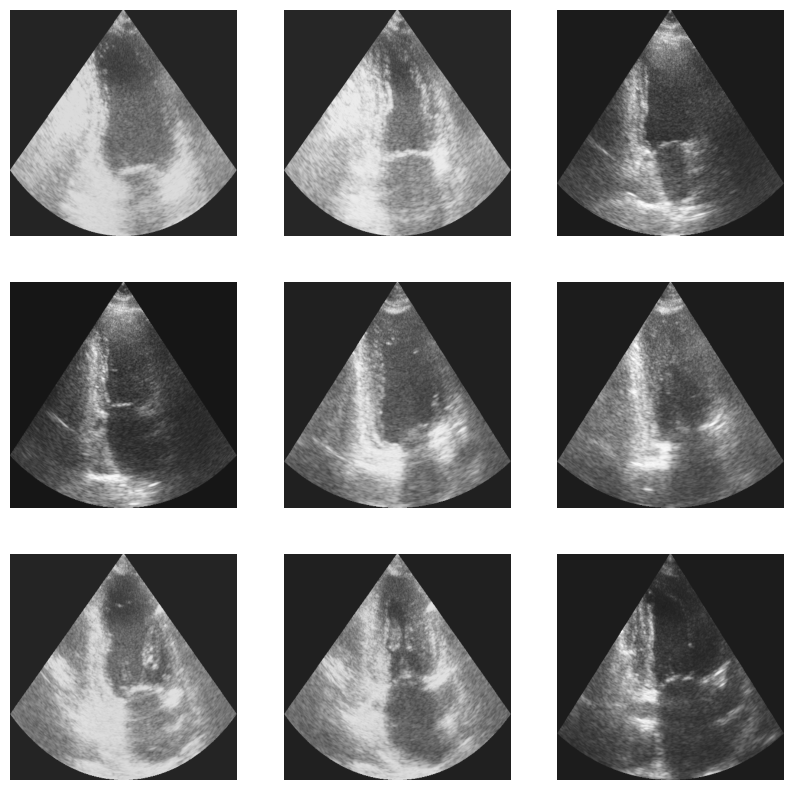

In [ ]:
# Visualization of masks:
#Input_images = os.listdir('write_dir/Mitotic_fig/masks')
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
# Loop through the first 9 images:
for i, image_file in enumerate(Images[:9]):
    # Display the image
    axes[i].imshow(image_file,cmap='gray')
    axes[i].axis('off')
    #axes[i].set_title("size-{}".format(image.shape))

## Visualization of ground truth of masks:

Endocardium and epicardium of the left ventricle and left atrium wall are shown respectively
in blue, green and yellow. in below masks.

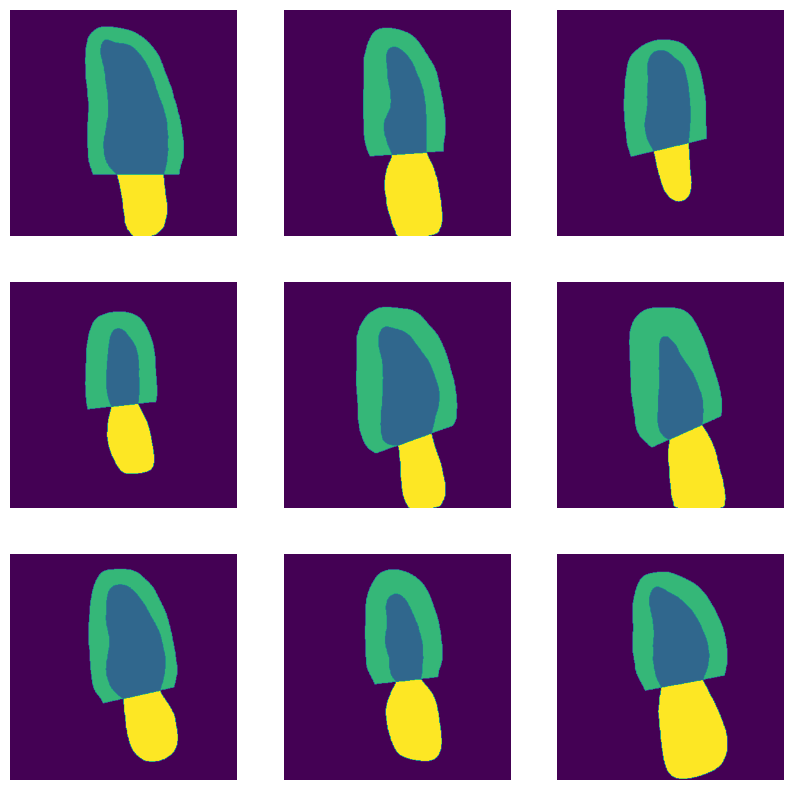

In [ ]:
# Visualization of masks:
#Input_images = os.listdir('write_dir/Mitotic_fig/masks')
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
# Loop through the first 9 images:
for i, image_file in enumerate(Masks[:9]):
    # Display the image
    axes[i].imshow(image_file)
    axes[i].axis('off')
    #axes[i].set_title("size-{}".format(image.shape))

In [6]:
type(Images)

numpy.ndarray

## Preprocessing:

In [7]:
# Define Gaussian blur kernel size and sigma
kernel_size = (5, 5)  # Kernel size
sigma = 1.0  # Standard deviation for the Gaussian kernel

# Iterate through each image and apply Gaussian blur
preprocessed_images = np.empty_like(Images)  # Create an empty array to store blurred images

for i in range(Images.shape[0]):
    # Extract the 2D image from the 3D shape (384, 384, 1)
    image = Images[i, :, :, 0]

    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)

    # Store the blurred image back in the array
    preprocessed_images[i, :, :, 0] = blurred_image

print("Gaussian blur applied to all images successfully.")

Gaussian blur applied to all images successfully.


In [8]:
preprocessed_images.shape

(900, 384, 384, 1)

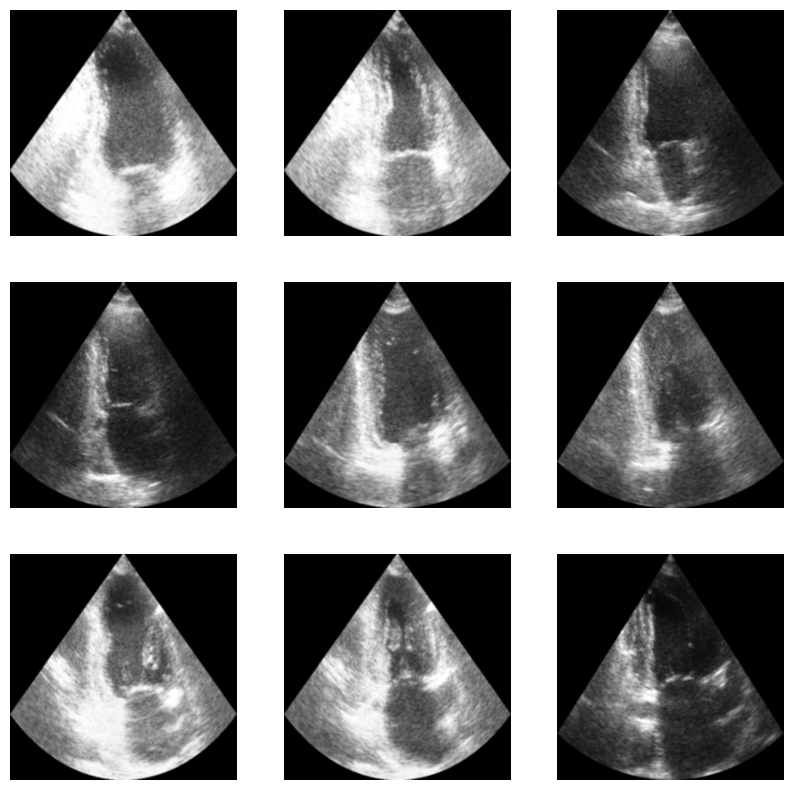

In [15]:
# Visualization of masks:
#Input_images = os.listdir('write_dir/Mitotic_fig/masks')
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
# Loop through the first 9 images:
for i, image_file in enumerate(preprocessed_images[:9]):
    # Display the image
    axes[i].imshow(image_file,cmap='gray')
    axes[i].axis('off')
    #axes[i].set_title("size-{}".format(image.shape))

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow.keras.backend as K
from tensorflow import argmax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split


In [17]:
#Splitting the dataset:
train_images, test_images, train_masks, test_masks = train_test_split(preprocessed_images, Masks)

## Creating Loss and Metrices Function:

In [18]:
# Loss function:
def generalized_dice_loss(y_true, y_pred, smooth=1e-7, num_classes=4):

    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return 1.0-K.mean((2. * intersect / (denom + smooth)))  #

In [19]:
# Metrices
def multiclass_dice(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))


def dice_lv(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:2])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,1:2])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_la(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,3:4])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,3:4])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_myo(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,2:3])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,2:3])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

## Building the Model Architecture:

In [20]:
drop = 0.25

def ResBlock(input_tensor, filters):

    conv_1 = Conv2D(filters = filters, kernel_size = 3, padding = 'same', kernel_initializer = 'he_normal')
    conv_1a = conv_1(input_tensor) # Shared weights conv layer
    batch_1 = BatchNormalization()(conv_1a)
    relu_1  = Activation("relu")(batch_1)
    drop_1  = Dropout(drop)(relu_1)
    conv_1b = conv_1(drop_1) # Shared weights conv layer
    batch_1 = BatchNormalization()(conv_1b)
    return batch_1

def Dual_UNet(input_size = (256, 256, 1), num_classes=2, filters=30):

    # X's denote standard flow
    # XNUM denote ResBlock outputs

    # "First" UNet

    # Input branch
    inputs = Input(input_size)
    X = Conv2D(filters=filters, kernel_size=3, activation="relu", padding = 'same', kernel_initializer = 'he_normal')(inputs)

    # Down branch
    X1 = ResBlock(input_tensor=X, filters=filters) # ResBlock located in the first layer of the paper scheme
    X = Conv2D(filters=filters*2, kernel_size=3, strides=2, kernel_initializer='he_normal')(X1)
    X = Activation("relu")(X) # This ReLU is not shown in the paper scheme

    X2 = ResBlock(input_tensor=X, filters=filters*2)
    X = Conv2D(filters=filters*4, kernel_size=3, strides=2, kernel_initializer='he_normal')(X2)
    X = Activation("relu")(X)

    X3 = ResBlock(input_tensor=X, filters=filters*4)
    X = Conv2D(filters=filters*8, kernel_size=3, strides=2, kernel_initializer='he_normal')(X3)
    X = Activation("relu")(X)

    X4 = ResBlock(input_tensor=X, filters=filters*8)
    X = Conv2D(filters=filters*16, kernel_size=3, strides=2, kernel_initializer='he_normal')(X4)
    X = Activation("relu")(X)

    # Bottom block
    X = ResBlock(input_tensor=X, filters=filters*16)

    # Up branch
    X = Conv2DTranspose(filters=filters*8, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Add()([X, X4])
    # X = Activation("relu")(X) # This ReLU is commented in the paper code
    X5 = ResBlock(input_tensor=X, filters=filters*8)

    X = Conv2DTranspose(filters=filters*4, kernel_size=3, strides=2, kernel_initializer='he_normal')(X5)
    X = Add()([X, X3])
    # X = Activation("relu")(X)
    X6 = ResBlock(input_tensor=X, filters=filters*4)

    X = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=2, kernel_initializer='he_normal')(X6)
    X = Add()([X, X2])
    # X = Activation("relu")(X)
    X7 = ResBlock(input_tensor=X, filters=filters*2)

    X = Conv2DTranspose(filters=filters, kernel_size=3, strides=2, output_padding=1, kernel_initializer='he_normal')(X7)
    X = Add()([X, X1])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters)

    # Top block (bottle-neck)
    X8 = ResBlock(input_tensor=X, filters=filters)
    X = ResBlock(input_tensor=X, filters=filters)
    X = Add()([X, X8])

    # "Second" UNet

    # Down branch
    X9 = ResBlock(input_tensor=X, filters=filters)
    X = Conv2D(filters=filters*2, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Activation("relu")(X)
    X = Add()([X7, X])

    X10 = ResBlock(input_tensor=X, filters=filters*2)
    X = Conv2D(filters=filters*4, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Activation("relu")(X)
    X = Add()([X6, X])

    X11 = ResBlock(input_tensor=X, filters=filters*4)
    X = Conv2D(filters=filters*8, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Activation("relu")(X)
    X = Add()([X5, X])

    X12 = ResBlock(input_tensor=X, filters=filters*8)
    X = Conv2D(filters=filters*16, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Activation("relu")(X)

    # Bottom block
    X = ResBlock(input_tensor=X, filters=filters*16)

    # Up branch
    X = Conv2DTranspose(filters=filters*8, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Add()([X, X12])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters*8)

    X = Conv2DTranspose(filters=filters*4, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Add()([X, X11])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters*4)

    X = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=2, kernel_initializer='he_normal')(X)
    X = Add()([X, X10])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters*2)

    X = Conv2DTranspose(filters=filters, kernel_size=3, strides=2, kernel_initializer='he_normal', output_padding=1)(X)
    X = Add()([X, X9])
    # X = Activation("relu")(X)
    X = ResBlock(input_tensor=X, filters=filters)

    # Final block
    X = Conv2D(filters=num_classes, kernel_size=1, kernel_initializer='he_normal')(X)
    # X = Activation("relu")(X)
    X = Activation("softmax")(X)
    #X = Conv2D(1, 1)(X)

    model = Model(inputs, X)

    return model

In [21]:
model_unet = Dual_UNet(input_size=(384, 384, 1), num_classes=4, filters=20)

In [22]:
earlystop = EarlyStopping(monitor='val_multiclass_dice', min_delta=0, patience=5,
                          verbose=1, mode="max", restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_multiclass_dice', factor=0.2, patience=2,
                              verbose=1, mode="max", min_lr=1e-5)

In [23]:
model_unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 384, 384, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 384, 384, 20)   │            200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 384, 384, 20)   │          3,620 │ conv2d[0][0],          │
│                           │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 384, 384, 20)   │             80 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 384, 384, 20)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 384, 384, 20)   │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 384, 384, 20)   │             80 │ conv2d_1[1][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 191, 191, 40)   │          7,240 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 191, 191, 40)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 191, 191, 40)   │         14,440 │ activation_1[0][0],    │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 191, 191, 40)   │            160 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 191, 191, 40)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 191, 191, 40)   │              0 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 191, 191, 40)   │            160 │ conv2d_3[1][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 95, 95, 80)     │         28,880 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 95, 95, 80)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)    

 Total params: 5,541,404 (21.14 MB)

 Trainable params: 5,533,884 (21.11 MB)

 Non-trainable params: 7,520 (29.38 KB)

In [24]:
model_unet.compile(optimizer=Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, "accuracy"])

In [25]:
history = model_unet.fit(x=train_images,
                    y=train_masks,
                    validation_data=[test_images, test_masks],
                    batch_size=5,
                    epochs=50,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 131s 475ms/step - accuracy: 0.7431 - loss: 0.8283 - multiclass_dice: 0.4250 - val_accuracy: 0.1811 - val_loss: 422.3673 - val_multiclass_dice: 0.2213 - learning_rate: 0.0010
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 99s 437ms/step - accuracy: 0.8990 - loss: 0.2884 - multiclass_dice: 0.7168 - val_accuracy: 0.8426 - val_loss: 1.2074 - val_multiclass_dice: 0.6332 - learning_rate: 0.0010
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 435ms/step - accuracy: 0.9142 - loss: 0.2328 - multiclass_dice: 0.7585 - val_accuracy: 0.5207 - val_loss: 20.0517 - val_multiclass_dice: 0.2476 - learning_rate: 0.0010
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 432ms/step - accuracy: 0.9180 - loss: 0.2217 - multiclass_dice: 0.7756 - val_accuracy: 0.9054 - val_loss: 0.3038 - val_multiclass_dice: 0.7553 - learning_rate: 0.0010
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 431ms/step - accuracy: 0.9227 - loss: 0.2035 - multiclass_dice: 0.7953 - val_accuracy: 0.8938 - val_loss: 0.

In [30]:
# saving the model
model_unet.save('model_unet_50ep.keras')

## Visualization of Training and Validation graphs:

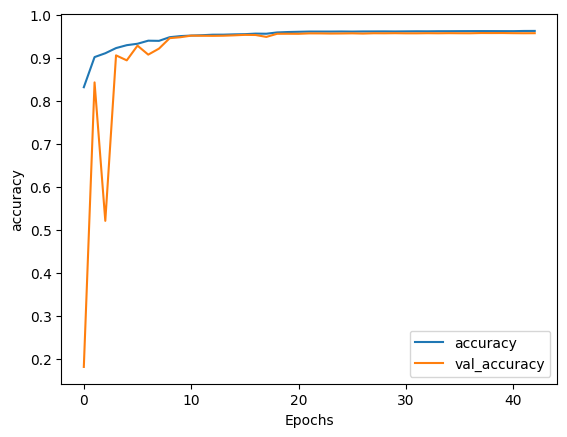

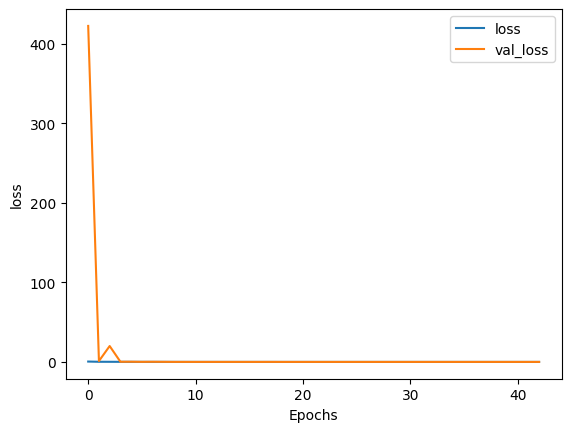

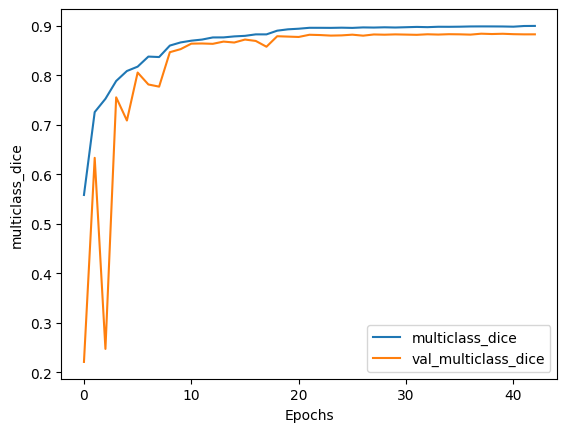

In [27]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
plot_graphs(history, "multiclass_dice")

In [28]:
# Convert to DataFrame
df = pd.DataFrame(history.history)

# Save to CSV
df.to_csv("training_metrics_50ep_1.csv", index=False)

print("Training metrics saved to 'training_metrics.csv'")

Training metrics saved to 'training_metrics.csv'


In [29]:
df

,accuracy,loss,multiclass_dice,val_accuracy,val_loss,val_multiclass_dice,learning_rate
0,0.831383,0.547976,0.558294,0.181099,422.367340,0.221301,0.00100
1,0.901428,0.276324,0.725548,0.842612,1.207379,0.633234,0.00100
2,0.910354,0.240766,0.752347,0.520670,20.051693,0.247560,0.00100
3,0.922356,0.206632,0.788313,0.905416,0.303752,0.755338,0.00100
4,0.929106,0.186980,0.808471,0.893849,0.346410,0.708565,0.00100
5,0.932438,0.175065,0.817268,0.928044,0.188599,0.805358,0.00100
6,0.939549,0.153841,0.837590,0.907127,0.286302,0.781286,0.00100
7,0.939179,0.155051,0.836650,0.921130,0.203909,0.776918,0.00100
8,0.947691,0.131019,0.859789,0.945462,0.133630,0.846430,0.00020
9,0.950214,0.122736,0.866151,0.947598,0.128953,0.852577,0.00020


## Visualization of Output Images:

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


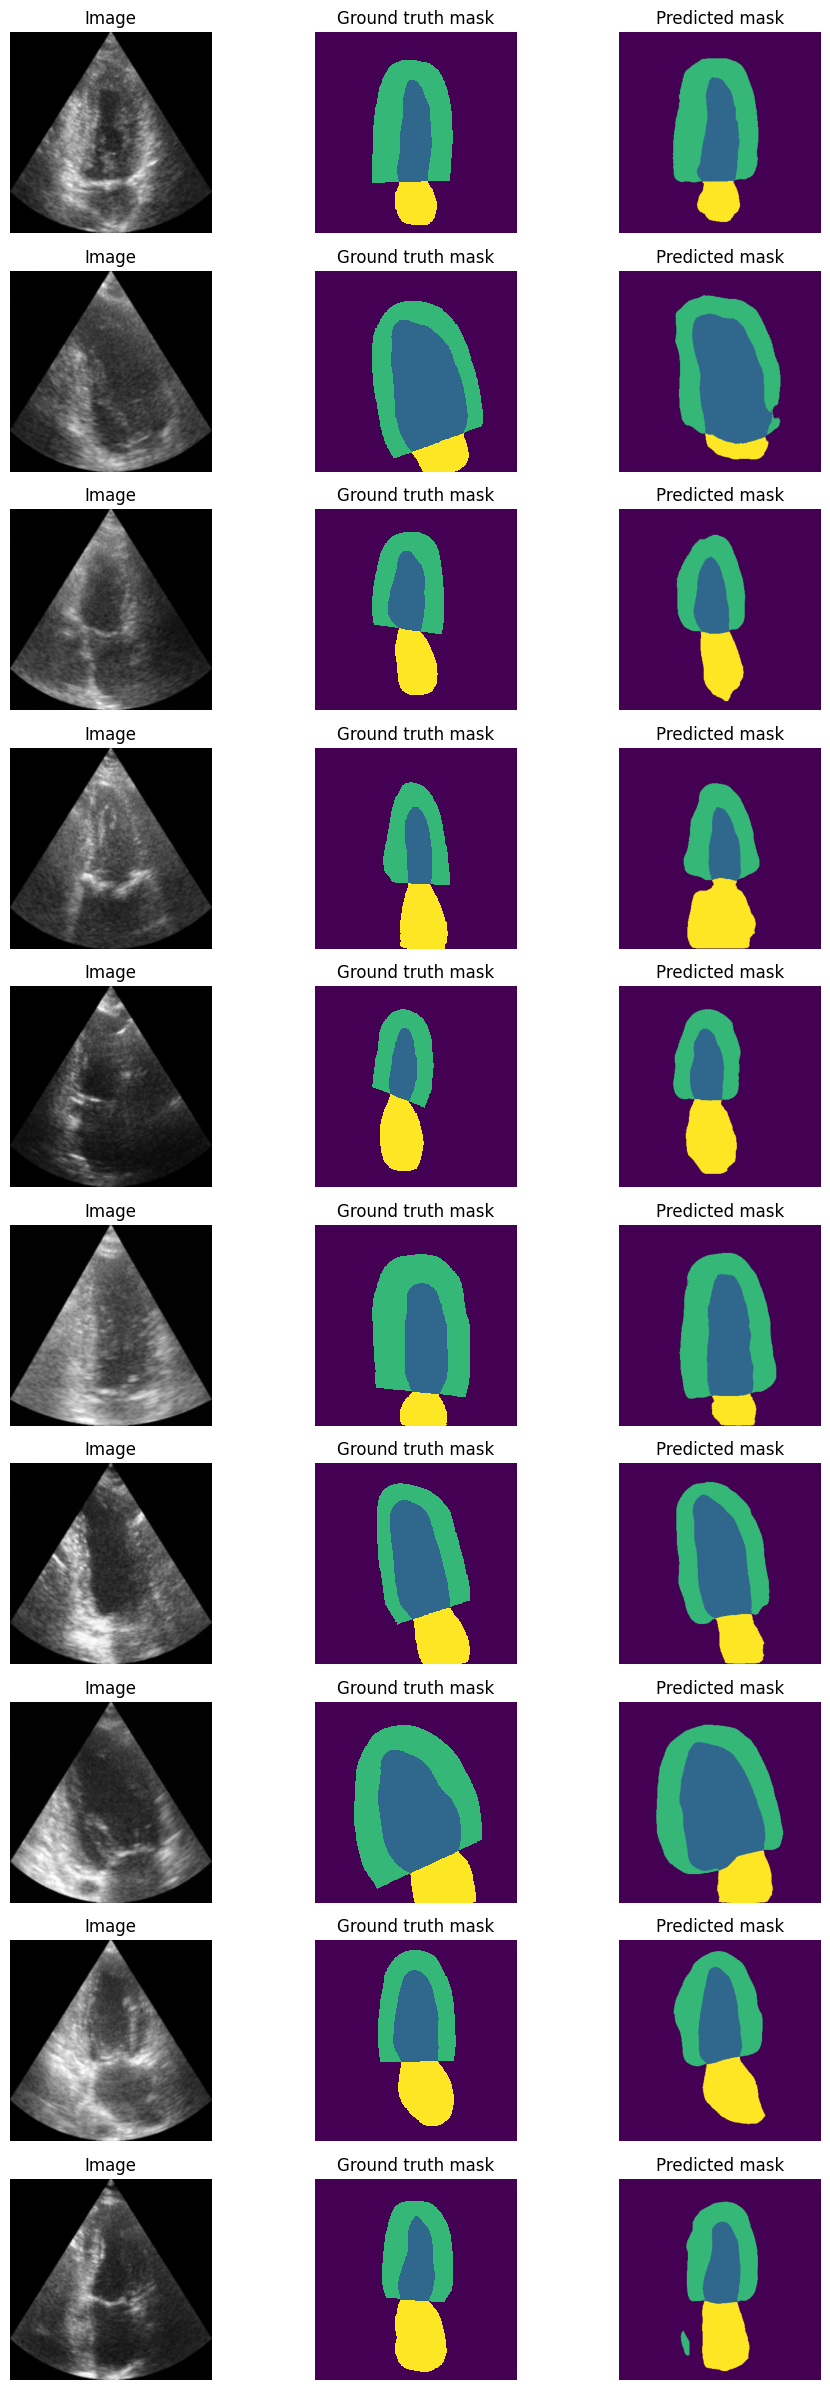

In [26]:
def display_image_grid(test_frames, test_masks, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = 10
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i in range(10):
        img = test_frames[i,:,:,0]
        mask = test_masks[i,:,:,0]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()


predicted_masks = []
for i in range(10):
    prediction = model_unet.predict(test_images[i:i+1,:,:,:])
    prediction = prediction.reshape([384, 384, 4])
    y = tf.convert_to_tensor(prediction)
    predicted_masks.append(tf.math.argmax(prediction, axis = 2))

display_image_grid(test_images, test_masks, predicted_masks=predicted_masks)



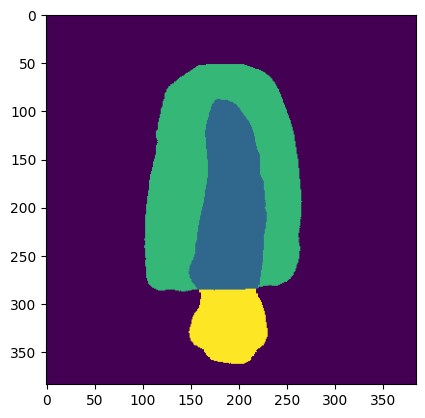

In [38]:
plt.imshow(predicted_masks[0])

## Saving the Output Segmented Images


In [45]:
predicted_masks = []
for i in range(len(preprocessed_images)):
    prediction = model_unet.predict(preprocessed_images[i:i+1,:,:,:])
    prediction = prediction.reshape([384, 384, 4])
    y = tf.convert_to_tensor(prediction)
    predicted_masks.append(tf.math.argmax(prediction, axis = 2))
    plt.imsave(f'Segmented_Output/{i}.png',predicted_masks[i])
    print(f'Segmented_Output{i}.png is saved')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Segmented_Output0.png is saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Segmented_Output1.png is saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Segmented_Output2.png is saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Segmented_Output3.png is saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Segmented_Output4.png is saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Segmented_Output5.png is saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Segmented_Output6.png is saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Segmented_Output7.png is saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Segmented_Output8.png is saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Segmented_Output9.png is saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Segmented_Output10.png is saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Segmented_Output11.png is saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Segmented_Output12.png is saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Segmented_Output13.png is saved
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75

## Feature Extraction using Color Co-occurrence Matrix (CCM):

In [10]:
import cv2
import numpy as np

def quantize_colors(image, num_bins=8):
    """Quantizes an image into fixed bins per channel (HSV space)"""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Convert to HSV
    bins = np.linspace(0, 256, num_bins + 1)  # Define bin edges
    quantized = np.digitize(hsv, bins) - 1  # Assign each pixel to a bin (0 to num_bins-1)
    return quantized

def compute_ccm(image, distance=1, num_bins=8):
    """Computes the Color Co-occurrence Matrix (CCM)"""
    quantized_image = quantize_colors(image, num_bins)
    h, w, _ = quantized_image.shape

    # Initialize CCM with valid bin size
    ccm = np.zeros((num_bins, num_bins), dtype=np.float32)

    # Iterate over image pixels (excluding edges)
    for y in range(h):
        for x in range(w - distance):  # Ensure index does not go out of bounds
            color1 = quantized_image[y, x, 0]  # Get bin index of first pixel (H Channel)
            color2 = quantized_image[y, x + distance, 0]  # Neighboring pixel (H Channel)

            if 0 <= color1 < num_bins and 0 <= color2 < num_bins:  # Valid indices check
                ccm[color1, color2] += 1  # Increment co-occurrence count

    # Normalize CCM
    ccm /= np.sum(ccm) if np.sum(ccm) > 0 else 1  # Avoid division by zero 
    return np.array(ccm.flatten(), dtype=np.float32)


In [11]:
preprocessed_images[0].shape

(384, 384, 1)

### LOADING SEGMENTED IMAGES

In [14]:
# Path to the folder containing images
folder_path = "Segmented_Output"

# List all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Initialize an empty list to store images
image_list = []

# Load images and convert them to NumPy arrays
for img_file in image_files:
    img_path = os.path.join(folder_path, img_file)
    img = cv2.imread(img_path)  # Read image using OpenCV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image_list.append(img)

# Convert list of images to a single NumPy array
Segmented_Image = np.array(image_list)

# Print shape of the final NumPy array
print("Loaded Image Array Shape:", Segmented_Image.shape)  # (num_images, height, width, channels)

Loaded Image Array Shape: (900, 384, 384, 3)


In [17]:
import os
import pandas as pd

# Prepare storage for features and labels
feature_list = []
label_list = []

for img_file in Segmented_Image:
        ccm_feat = compute_ccm(img_file)
        feature_list.append(ccm_feat)
                       

# Save to CSV
features_df = pd.DataFrame(feature_list)
csv_output_path = 'color_co-ocurrence_features_.csv'
features_df.to_csv(csv_output_path, index=False)
print(f"CCM feature extraction complete.")  

CCM feature extraction complete.


In [19]:
features_df.head(15)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.130460,0.001516,0.000109,0.0,0.000000,0.0,0.0,0.0,0.001564,0.117976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.070292,0.001265,0.000068,0.0,0.000000,0.0,0.0,0.0,0.001319,0.111163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.076269,0.001047,0.000088,0.0,0.000007,0.0,0.0,0.0,0.001142,0.087474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.097884,0.001407,0.000082,0.0,0.000020,0.0,0.0,0.0,0.001509,0.150423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.067933,0.001312,0.000020,0.0,0.000014,0.0,0.0,0.0,0.001312,0.127591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.208816,0.001679,0.000252,0.0,0.000007,0.0,0.0,0.0,0.001938,0.132262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.171039,0.001475,0.000150,0.0,0.000007,0.0,0.0,0.0,0.001632,0.118697,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.058502,0.001115,0.000435,0.0,0.000020,0.0,0.0,0.0,0.001414,0.093628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.027334,0.000789,0.000034,0.0,0.000000,0.0,0.0,0.0,0.000809,0.064213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.130188,0.000938,0.000381,0.0,0.000007,0.0,0.0,0.0,0.001326,0.109695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## LSTM MODEL ARCHITECTURE:

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense,Conv1D,MaxPooling1D,LSTM

from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy,categorical_crossentropy,CategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy,categorical_accuracy,CategoricalAccuracy,sparse_categorical_accuracy,Accuracy

def create_keras_model():
    # # Create sequential model  
    model = Sequential()
    #Fist CNN layer with 512 filters, kernel_size=5, relu activation with valid padding
    model.add(Conv1D(filters=512, kernel_size=5, activation='relu', input_shape=(20,1),padding='valid'))
    model.add(MaxPooling1D(pool_size=2))
    #Second CNN layer with 128 filters, kernel_size=2, relu activation with valid padding
    model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(20,1),padding='valid'))
    model.add(MaxPooling1D(pool_size=2))
    #Add a LSTM layer with 100 neurons
    model.add(LSTM(100,  activation='relu'))
    model.add(Dropout(0.5))
    #Add a dense layer with 100 neurons
    model.add(Dense(100,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    # Softmax as last layer with seven outputs
    model.add(Dense(14, activation='softmax'))
    #Compile the model using Adam optimizer with learning rate
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

# Summary model
keras_model = create_keras_model()
keras_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 512)           3072      
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 512)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 128)            131200    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 128)            0         
 g1D)                                                            
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dropout (Dropout)           (None, 100)              